In [83]:
REPO = '../'
RESULT_TABLE = f'{REPO}/data/table'
RESULT_OBJ = f'{REPO}/data/object'
FIGURE_FOLDER= f'{REPO}/data/figure'
SETTING_FOLDER = f'{REPO}/data/setting'
EXTERNAL_DATA=f'{REPO}/data/external'

# load Terra API for get data table from Terra
import sys
import glob
sys.path.append(REPO)
from settings import COLOR_PAlETTE
from utils.visual import *

# load packages and data for the following analysis
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import textalloc as ta
import scanpy as sc
import scPipe as sp
from adjustText import adjust_text
import warnings
import commentjson
### Additional Colormap
with open(f'{SETTING_FOLDER}/ColorMap.json','r') as f:
    colormap = commentjson.load(f)
COLOR_PAlETTE.update(colormap)
plt.style.use(f'{REPO}/paper.mplstyle')
warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
adata = sc.read(f'{RESULT_OBJ}/gex_all.h5ad')
sp.utils.log1pNorm(adata)
## add celltype 
for lineage in ['T','Myeloid','Epithelial']:
    lineage_anno = pd.read_csv(f'{RESULT_TABLE}/annotation/{lineage}.csv',index_col=0)
    celltype = lineage_anno['Celltype'] if 'Celltype' in lineage_anno else lineage_anno['Lineage']
    adata.obs.loc[celltype.index,'Celltype'] = celltype
## add cellstate
for celltype in ['CD8T','Macs','Tumor']:
    cellstate = pd.read_csv(f'{RESULT_TABLE}/MPs/{celltype}/Annotation.csv',index_col=0)['Cellstate']
    adata.obs.loc[cellstate.index,'Cellstate'] = cellstate

# Prioritize L-R table

In [85]:
interaction_baseline_path = f"{RESULT_TABLE}/multinichenetR/multinichenetr_NR_vs_R_Baseline_Top3000_per_group.tsv"
interaction_delta_path = f"{RESULT_TABLE}/multinichenetR/multinichenetr_NR_vs_R_Delta_Top3000_per_group.tsv"

In [86]:
celltype_io = ['CD8T','Macs','Tumor']
cm_bl = pd.read_csv(interaction_baseline_path,sep='\t')
lr_prod_bl = pd.read_csv(f'{RESULT_TABLE}/multinichenetR/multinichenetr_NR_vs_R_Baseline_sample_prioritization_tbl.tsv',sep='\t')
pr_bl =  pd.read_csv(f'{RESULT_TABLE}/multinichenetR/multinichenetr_NR_vs_R_Baseline_group_prioritization_tbl.tsv',sep='\t')
## filtering as multinitchnet recom
lr_prob_bl = lr_prod_bl.loc[lr_prod_bl.sender.isin(celltype_io)&
    lr_prod_bl.receiver.isin(celltype_io),
:]
pr_bl = pr_bl.loc[pr_bl.sender.isin(celltype_io)&
    pr_bl.receiver.isin(celltype_io)&
    (pr_bl.group==pr_bl.top_group)&
    (pr_bl.fraction_expressing_ligand_receptor > 0),
:].drop_duplicates(['group', 'sender', 'receiver', 'ligand', 'receptor', 'receiver', 'id', 'prioritization_score'])

cm_delta = pd.read_csv(interaction_delta_path,sep='\t')
lr_prod_delta = pd.read_csv(f'{RESULT_TABLE}/multinichenetR/multinichenetr_NR_vs_R_Delta_sample_prioritization_tbl.tsv',sep='\t')
pr_delta =  pd.read_csv(f'{RESULT_TABLE}/multinichenetR/multinichenetr_NR_vs_R_Delta_group_prioritization_tbl.tsv',sep='\t')

## filtering as multinitchnet recom
lr_prod_deltal = lr_prod_delta.loc[
    lr_prod_delta.sender.isin(celltype_io)&
    lr_prod_delta.receiver.isin(celltype_io),
:]
pr_delta = pr_delta.loc[pr_delta.sender.isin(celltype_io)&
    pr_delta.receiver.isin(celltype_io)&
    (pr_delta.group==pr_delta.top_group)&
    (pr_delta.fraction_expressing_ligand_receptor > 0),
:].drop_duplicates(['group', 'sender', 'receiver', 'ligand', 'receptor', 'receiver', 'id', 'prioritization_score'])


## PD1-PDL1
### Baseline

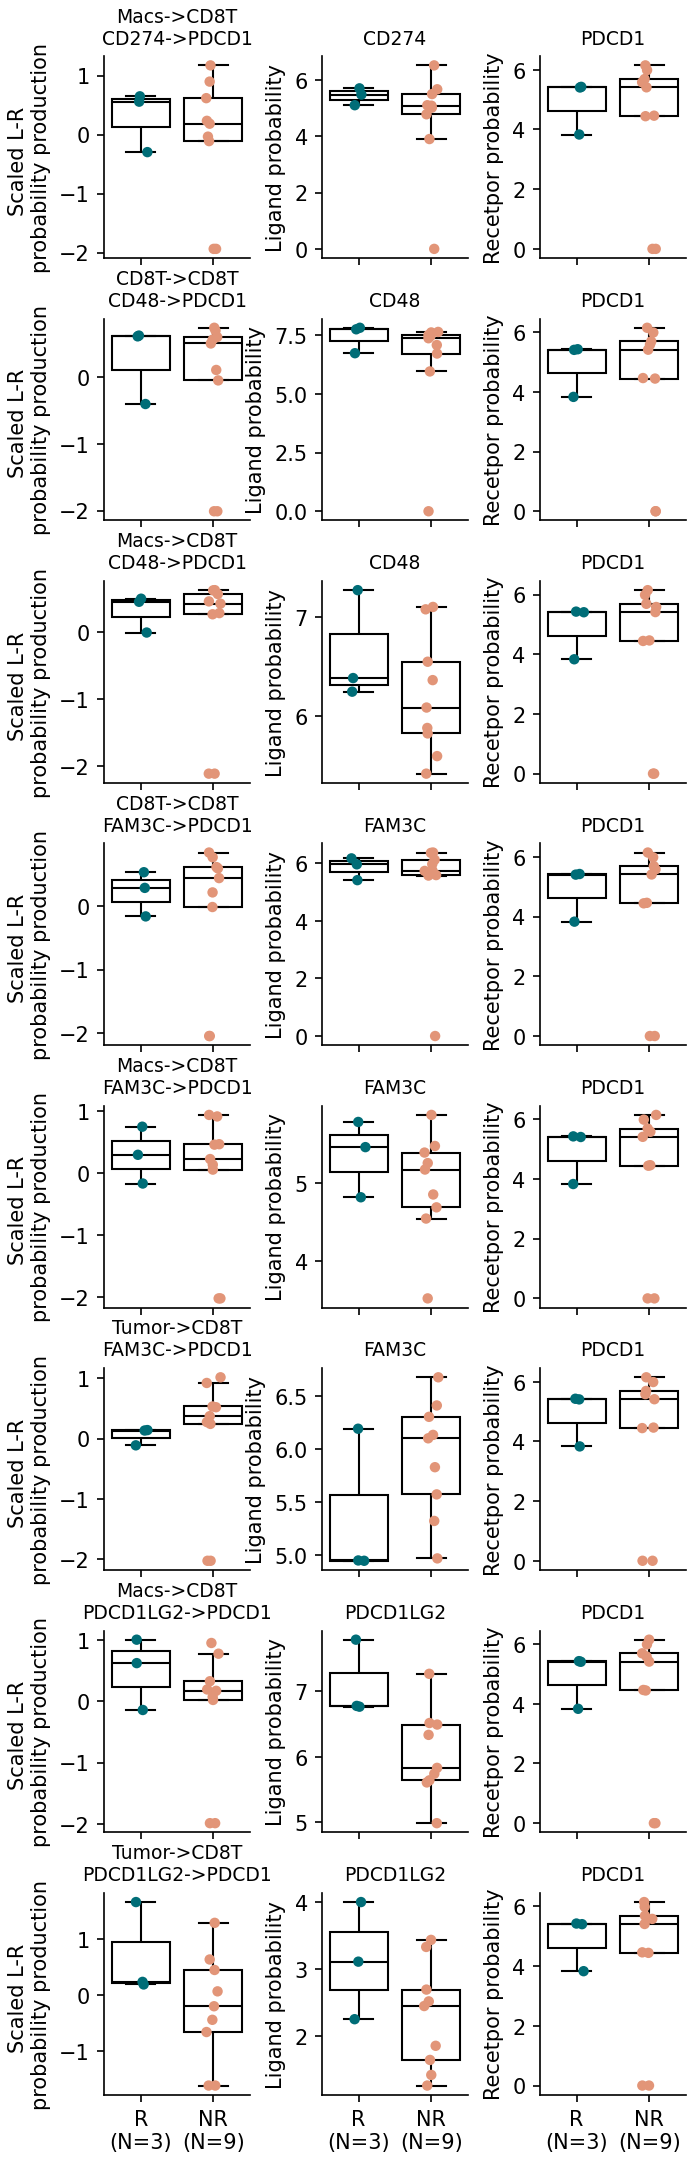

In [87]:
pd1_ids = lr_prob_bl.index[(lr_prob_bl.receptor=='PDCD1')&(lr_prob_bl.receiver=='CD8T')]

pd1_data =lr_prob_bl.loc[pd1_ids,:]
fig,axs = plt.subplots(pd1_data.id.nunique(),3,dpi=150,figsize=(5,pd1_data.id.nunique()*2+2),sharex=False)
order = ['R','NR']
for i,(lr,data) in enumerate(pd1_data.groupby('id')):
    data['group'] =data['group'].str.replace('_Baseline','')
    ax = axs[i,0]
    small_sample_box_visual(
        dt=data,
        x='group',y='scaled_LR_pb_prod',
        palette={'R':COLOR_PAlETTE['BestResponse']['favorable response\n(RCB 0-I)'],
                'NR':COLOR_PAlETTE['BestResponse']['unfavorable response\n(RCB II-III)']},
        order=order,
        ax=ax
    )
    ax.set(xlabel='',ylabel='Scaled L-R \nprobability production')
    ax.set_title('->'.join(lr.split('_')[2:]) +'\n' +'->'.join(lr.split('_')[:2]),size=9)
    if i !=pd1_data.id.nunique()-1:
        ax.set_xticklabels([])
        
    ax = axs[i,1]
    small_sample_box_visual(
        dt=data,
        x='group',y='pb_ligand',
        palette={'R':COLOR_PAlETTE['BestResponse']['favorable response\n(RCB 0-I)'],
                'NR':COLOR_PAlETTE['BestResponse']['unfavorable response\n(RCB II-III)']},
        order=order,
        ax=ax
    )
    ax.set(xlabel='',ylabel='Ligand probability')
    ax.set_title(lr.split('_')[0],size=9)
    if i !=pd1_data.id.nunique()-1:
        ax.set_xticklabels([])

    ax = axs[i,2]
    small_sample_box_visual(
        dt=data,
        x='group',y='pb_receptor',
        palette={'R':COLOR_PAlETTE['BestResponse']['favorable response\n(RCB 0-I)'],
                'NR':COLOR_PAlETTE['BestResponse']['unfavorable response\n(RCB II-III)']},
        order=order,
        ax=ax
    )
    ax.set(xlabel='',ylabel='Recetpor probability')
    ax.set_title(lr.split('_')[1],size=9)
    if i !=pd1_data.id.nunique()-1:
        ax.set_xticklabels([])
plt.subplots_adjust(wspace=.5,hspace=.3)

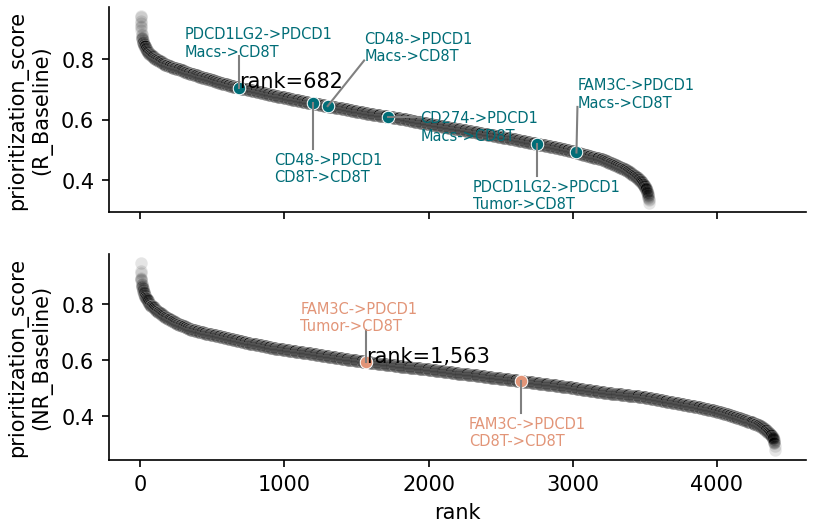

In [88]:
fig,axs=plt.subplots(2,1,dpi=150,sharex=True)
x = 'rank'
y = 'prioritization_score'


ax =axs[0]
group = 'R_Baseline'
data = pr_bl.loc[pr_bl.group==group,:].copy()
data['rank'] = data['prioritization_score'].rank(ascending=False)
sns.scatterplot(data=data,x=x,y=y,color='k',ax=ax,linewidth=0.3,alpha=0.1)
sub_data = data.loc[data.receptor=='PDCD1',:]
sns.scatterplot(data=sub_data,x=x,y=y,ax=ax,color=COLOR_PAlETTE['BestResponse']['favorable response\n(RCB 0-I)'])
t_x = sub_data[x].values
t_y = sub_data[y].values
t_s = sub_data['id'].map(lambda x:'->'.join(x.split('_')[:2]) + '\n' + '->'.join(x.split('_')[2:])).tolist()
ta.allocate(ax,t_x,t_y,t_s,x_scatter=t_x,y_scatter=t_y,
            textcolor=COLOR_PAlETTE['BestResponse']['favorable response\n(RCB 0-I)'],
            textsize=7,
            min_distance=0.01,
            margin=0.1,
            linecolor='gray')
ax.text(x=sub_data[x].min()+1,
        y=sub_data[y].max(),
        s=f"rank={sub_data[x].min():,.0f}",ha='left')
ax.set(ylabel=f'{y}\n({group})')
# ax.legend(loc=(0,1),ncols=2)



ax =axs[1]
group = 'NR_Baseline'
data = pr_bl.loc[pr_bl.group==group,:].copy()
data['rank'] = data['prioritization_score'].rank(ascending=False)
sns.scatterplot(data=data,x=x,y=y,color='k',ax=ax,linewidth=0.3,alpha=0.1)
sub_data = data.loc[data.receptor=='PDCD1',:]
sns.scatterplot(data=sub_data,x=x,y=y,ax=ax,color=COLOR_PAlETTE['BestResponse']['unfavorable response\n(RCB II-III)'])


t_x = sub_data[x].values
t_y = sub_data[y].values
t_s = sub_data['id'].map(lambda x:'->'.join(x.split('_')[:2]) + '\n' + '->'.join(x.split('_')[2:])).tolist()
ta.allocate(ax,t_x,t_y,t_s,x_scatter=t_x,y_scatter=t_y,
            textcolor=COLOR_PAlETTE['BestResponse']['unfavorable response\n(RCB II-III)'],
            textsize=7,
            min_distance=0.01,
            margin=0.1,
            linecolor='gray')
ax.set(ylabel=f'{y}\n({group})');
ax.text(x=sub_data[x].min()+1,
        y=sub_data[y].max(),
        s=f"rank={sub_data[x].min():,.0f}",ha='left');



## immune checkpoins Tumor-CD8T

In [89]:
theraputic_r=['PDCD1','TIGIT','LAG3','CTLA4','HAVCR2','BTLA']
top_n=50
cd8_tumor_pr_bl = pr_bl.loc[(pr_bl.sender=='Tumor')&
                            (pr_bl.receiver=='CD8T')].copy()

cd8_tumor_pr_bl['rank']= cd8_tumor_pr_bl.groupby(['group'])['prioritization_score'].rank(ascending=False)
lr_ids = (cd8_tumor_pr_bl.
          lr_interaction[(cd8_tumor_pr_bl['rank']<top_n) & (cd8_tumor_pr_bl.receptor.isin(theraputic_r))].
          unique()
         )
lr_ids

array(['NECTIN2_TIGIT', 'NECTIN4_TIGIT', 'WBP1_CTLA4', 'FAM200A_CTLA4'],
      dtype=object)

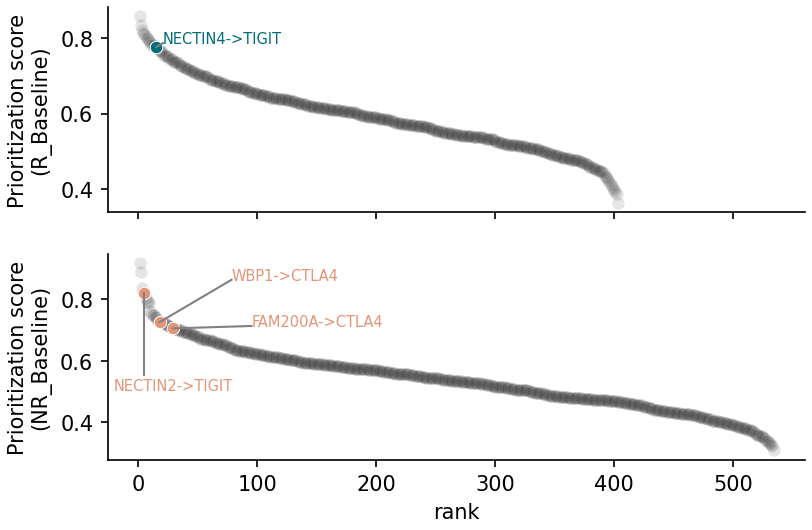

In [90]:
palette = {
    'NECTIN2_TIGIT':'steelblue',
    'NECTIN4_TIGIT':'skyblue',
    'SIRPA_TIGIT':'deepskyblue',
    'PVR_TIGIT':'darkblue',
    'WBP1_CTLA4':'green', 
    'FAM200A_CTLA4':'lime',
    'CEACAM1_HAVCR2':'orange',
    'HLA.DRB1_LAG3':'purple'
}
fig,axs=plt.subplots(2,1,dpi=150,sharex=True)
x = 'rank'
y = 'prioritization_score'


ax =axs[0]
group = 'R_Baseline'
data = cd8_tumor_pr_bl.loc[cd8_tumor_pr_bl.group==group,:].copy()
data['rank'] = data['prioritization_score'].rank(ascending=False)
sns.scatterplot(data=data,x=x,y=y,color='k',ax=ax,linewidth=0.3,alpha=0.1)
sub_data = data.loc[data.lr_interaction.isin(lr_ids),:]
sns.scatterplot(data=sub_data,x=x,y=y,ax=ax,color=COLOR_PAlETTE['BestResponse']['favorable response\n(RCB 0-I)'])#,hue='lr_interaction',ax=ax,palette=palette)

# ax.text(x=sub_data[x].min()+1,
#         y=sub_data[y].max(),
#         s=f"rank={sub_data[x].min():,.0f}",ha='left')

t_x = sub_data[x].values
t_y = sub_data[y].values
t_s = sub_data['id'].map(lambda x:'->'.join(x.split('_')[:2])).tolist() #+ '\n' + '->'.join(x.split('_')[2:])).tolist()
ta.allocate(ax,t_x,t_y,t_s,x_scatter=t_x,y_scatter=t_y,
            textcolor=COLOR_PAlETTE['BestResponse']['favorable response\n(RCB 0-I)'],
            textsize=7,
            linecolor='gray')

ax.set(ylabel=f"{y.capitalize().replace('_',' ')}\n({group})");
# ax.legend(loc=(0,1),ncols=5)


ax =axs[1]
group = 'NR_Baseline'
data = cd8_tumor_pr_bl.loc[cd8_tumor_pr_bl.group==group,:].copy()
data['rank'] = data['prioritization_score'].rank(ascending=False)
sns.scatterplot(data=data,x=x,y=y,color='k',ax=ax,linewidth=0.3,alpha=0.1)
sub_data = data.loc[data.lr_interaction.isin(lr_ids),:]
sns.scatterplot(data=sub_data,x=x,y=y,ax=ax,color=COLOR_PAlETTE['BestResponse']['unfavorable response\n(RCB II-III)'])

# ax.text(x=sub_data[x].min()+1,
#         y=sub_data[y].max(),
#         s=f"rank={sub_data[x].min():,.0f}",ha='left')
# ax.legend(loc=(0,-.5),ncols=5)
t_x = sub_data[x].values
t_y = sub_data[y].values
t_s = sub_data['id'].map(lambda x:'->'.join(x.split('_')[:2])).tolist() #+ '\n' + '->'.join(x.split('_')[2:])).tolist()
ta.allocate(ax,t_x,t_y,t_s,x_scatter=t_x,y_scatter=t_y,
            textcolor=COLOR_PAlETTE['BestResponse']['unfavorable response\n(RCB II-III)'],
            textsize=7,
            # direction='northeast',
            max_distance=0.29,
            margin=.1,
            linecolor='gray')

ax.set(ylabel=f"{y.capitalize().replace('_',' ')}\n({group})");

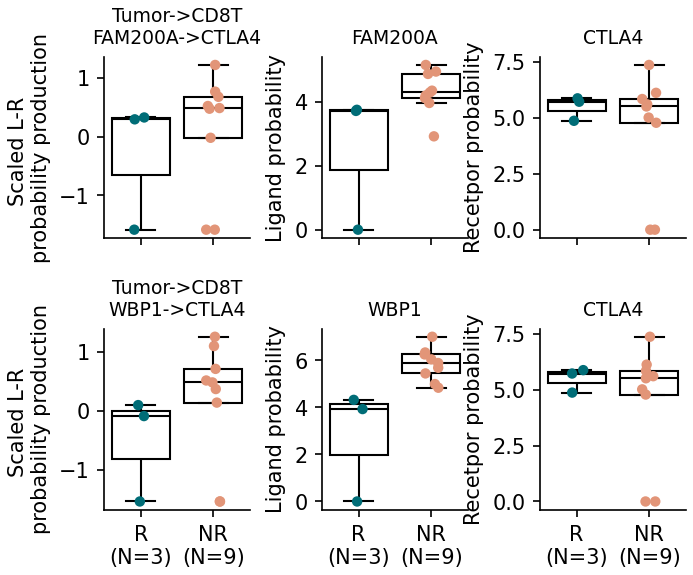

In [91]:
top_n = 3
fig,axs = plt.subplots(2,3,dpi=150,figsize=(5,4),sharex=False)
lr_ids_cell = cd8_tumor_pr_bl.id[cd8_tumor_pr_bl.lr_interaction.isin(['WBP1_CTLA4', 'FAM200A_CTLA4'] )]
dt = lr_prod_bl.loc[lr_prod_bl.id.isin(lr_ids_cell),:]
order = ['R','NR']
for i,(lr,data) in enumerate(dt.groupby('id')):
    data['group'] =data['group'].str.replace('_Baseline','')
    ax = axs[i,0]
    small_sample_box_visual(
        dt=data,
        x='group',y='scaled_LR_pb_prod',
        palette={'R':COLOR_PAlETTE['BestResponse']['favorable response\n(RCB 0-I)'],
                'NR':COLOR_PAlETTE['BestResponse']['unfavorable response\n(RCB II-III)']},
        order=order,
        ax=ax
    )
    ax.set(xlabel='',ylabel='Scaled L-R \nprobability production')
    ax.set_title('->'.join(lr.split('_')[2:]) +'\n' +'->'.join(lr.split('_')[:2]),size=9)
    if i !=1:
        ax.set_xticklabels([])
        
    ax = axs[i,1]
    small_sample_box_visual(
        dt=data,
        x='group',y='pb_ligand',
        palette={'R':COLOR_PAlETTE['BestResponse']['favorable response\n(RCB 0-I)'],
                'NR':COLOR_PAlETTE['BestResponse']['unfavorable response\n(RCB II-III)']},
        order=order,
        ax=ax
    )
    ax.set(xlabel='',ylabel='Ligand probability')
    ax.set_title(lr.split('_')[0],size=9)
    if i !=1:
        ax.set_xticklabels([])

    ax = axs[i,2]
    small_sample_box_visual(
        dt=data,
        x='group',y='pb_receptor',
        palette={'R':COLOR_PAlETTE['BestResponse']['favorable response\n(RCB 0-I)'],
                'NR':COLOR_PAlETTE['BestResponse']['unfavorable response\n(RCB II-III)']},
        order=order,
        ax=ax
    )
    ax.set(xlabel='',ylabel='Recetpor probability')
    ax.set_title(lr.split('_')[1],size=9)
    if i !=1:
        ax.set_xticklabels([])
plt.subplots_adjust(wspace=.5,hspace=.5)

## Tumor -Macs 

In [92]:
macs_tumor_pr_bl = pr_bl.loc[(pr_bl.sender.isin(['Tumor']))&
                            (pr_bl.receiver.isin(['Macs']))].copy()
top_n=5

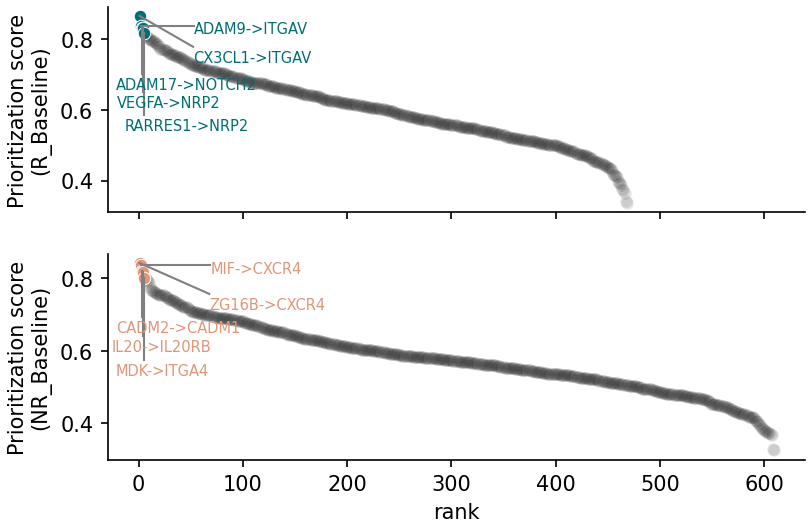

In [93]:
macs_marker_genes = {}
tumor_marker_genes = {}
fig,axs=plt.subplots(2,1,dpi=150,sharex=True)
x = 'rank'
y = 'prioritization_score'


ax =axs[0]
group = 'R_Baseline'
data = macs_tumor_pr_bl.loc[macs_tumor_pr_bl.group==group,:].copy()
data['rank'] = data['prioritization_score'].rank(ascending=False)
sns.scatterplot(data=data,x=x,y=y,color='k',ax=ax,linewidth=0.3,alpha=0.1)
sub_data = data.sort_values([y],ascending=False).head(top_n)
sns.scatterplot(data=sub_data,x=x,y=y,ax=ax,color=COLOR_PAlETTE['BestResponse']['favorable response\n(RCB 0-I)'])#,hue='lr_interaction',ax=ax,palette=palette)

# ax.text(x=sub_data[x].min()+1,
#         y=sub_data[y].max(),
#         s=f"rank={sub_data[x].min():,.0f}",ha='left')

t_x = sub_data[x].values
t_y = sub_data[y].values
t_s = sub_data['id'].map(lambda x:'->'.join(x.split('_')[:2])).tolist() #+ '\n' + '->'.join(x.split('_')[2:])).tolist()
macs_marker_genes[group] = sub_data['receptor'].unique().tolist()
tumor_marker_genes[group] = sub_data['ligand'].unique().tolist()
ta.allocate(ax,t_x,t_y,t_s,x_scatter=t_x,y_scatter=t_y,
            textcolor=COLOR_PAlETTE['BestResponse']['favorable response\n(RCB 0-I)'],
            textsize=7,
            max_distance=0.29,
            min_distance=.1,
            margin=.001,
            linecolor='gray')

ax.set(ylabel=f"{y.capitalize().replace('_',' ')}\n({group})");


ax =axs[1]
group = 'NR_Baseline'
data = macs_tumor_pr_bl.loc[macs_tumor_pr_bl.group==group,:].copy()
data['rank'] = data['prioritization_score'].rank(ascending=False)
sns.scatterplot(data=data,x=x,y=y,color='k',ax=ax,linewidth=0.3,alpha=0.1)
sub_data = data.sort_values([y],ascending=False).head(top_n)
sns.scatterplot(data=sub_data,x=x,y=y,ax=ax,color=COLOR_PAlETTE['BestResponse']['unfavorable response\n(RCB II-III)'])

# ax.text(x=sub_data[x].min()+1,
#         y=sub_data[y].max(),
#         s=f"rank={sub_data[x].min():,.0f}",ha='left')
# ax.legend(loc=(0,-.5),ncols=5)
t_x = sub_data[x].values
t_y = sub_data[y].values
t_s = sub_data['id'].map(lambda x:'->'.join(x.split('_')[:2])).tolist() #+ '\n' + '->'.join(x.split('_')[2:])).tolist()
macs_marker_genes[group] = sub_data['receptor'].unique().tolist()
tumor_marker_genes[group] = sub_data['ligand'].unique().tolist()
ta.allocate(ax,t_x,t_y,t_s,x_scatter=t_x,y_scatter=t_y,
            textcolor=COLOR_PAlETTE['BestResponse']['unfavorable response\n(RCB II-III)'],
            textsize=7,
            # direction='northeast',
            max_distance=0.29,
            min_distance=.1,
            margin=.001,
            linecolor='gray')

ax.set(ylabel=f"{y.capitalize().replace('_',' ')}\n({group})");

### Receptor expression on macrophage

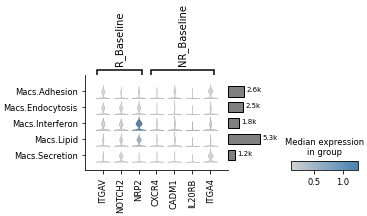

In [94]:
dp = sc.pl.stacked_violin(
    adata[adata.obs.Celltype=='Macs',:],macs_marker_genes,
    groupby='Cellstate',
    cmap=sns.blend_palette(["lightgray", "steelblue"], as_cmap=True),
    vmin=.1,
    return_fig=True)
dp.add_totals(color='gray').show()

### Boxplot visual

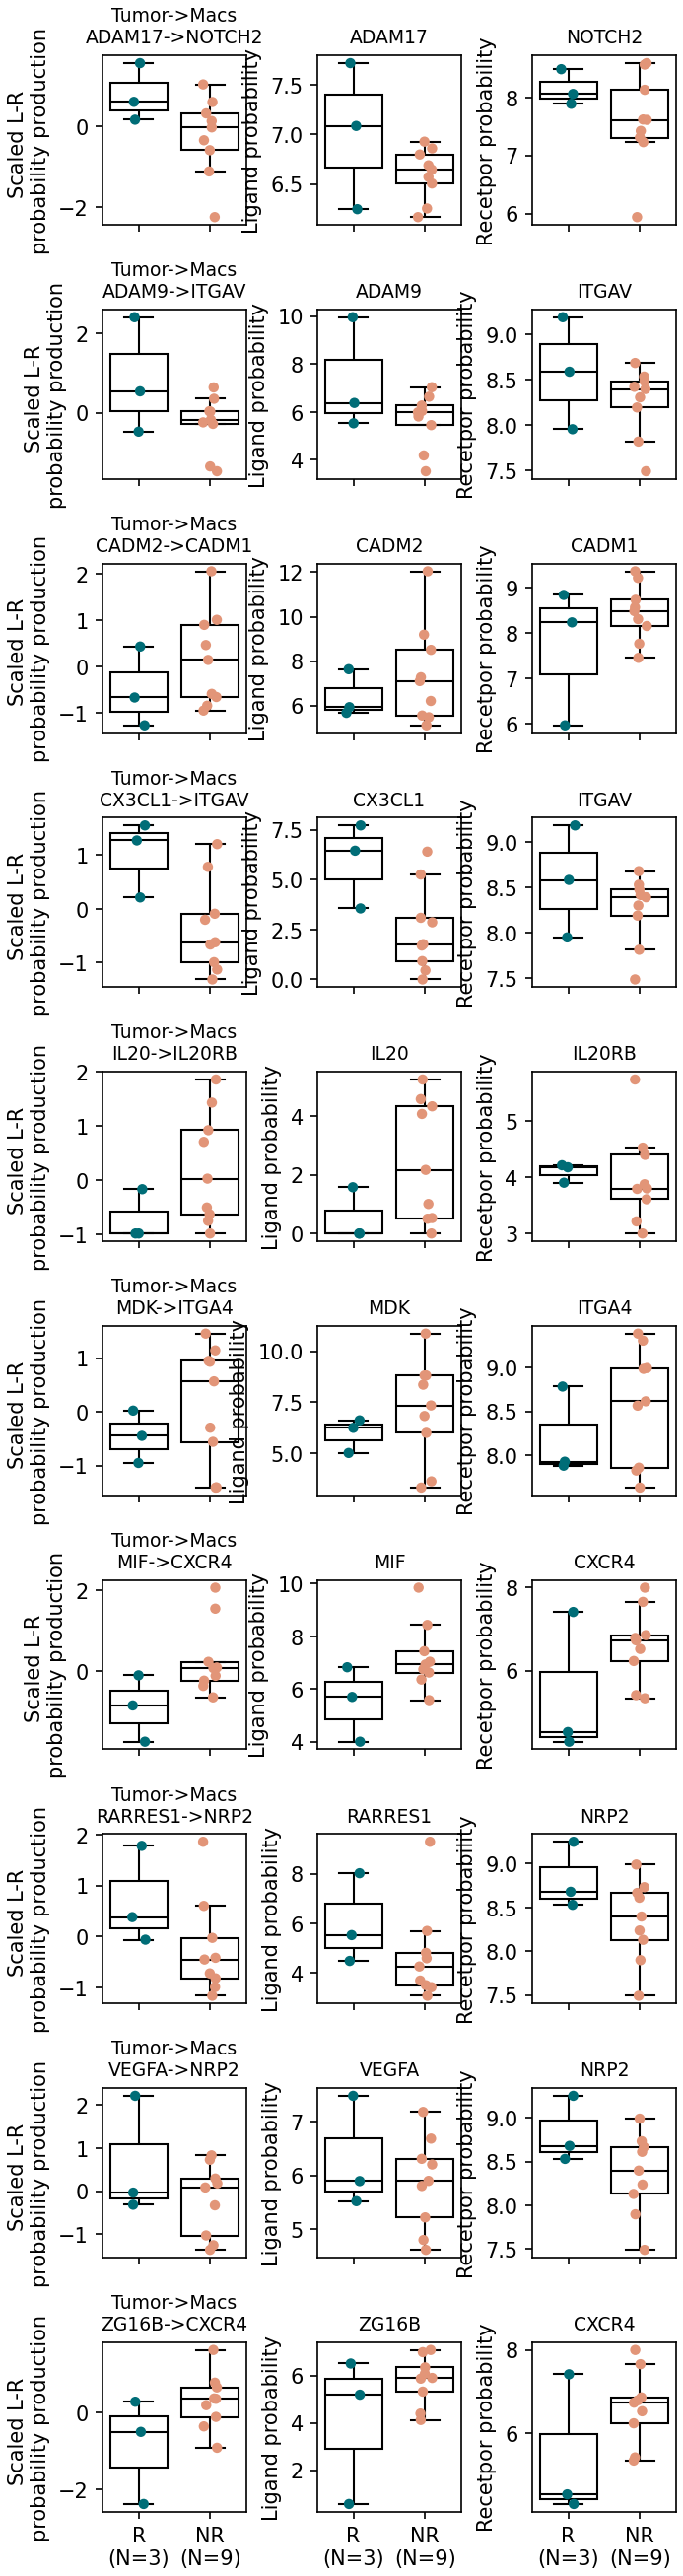

In [11]:
fig,axs = plt.subplots(top_n*2,3,dpi=150,figsize=(5,top_n*4+2),sharex=False)
macs_tumor_pr_bl['rank'] = macs_tumor_pr_bl.groupby('group')['prioritization_score'].rank(ascending=False)
lr_ids = macs_tumor_pr_bl.id[macs_tumor_pr_bl['rank']<=top_n]
dt = lr_prod_bl.loc[lr_prod_bl.id.isin(lr_ids),:]
order = ['R','NR']
for i,(lr,data) in enumerate(dt.groupby('id')):
    data['group'] =data['group'].str.replace('_Baseline','')
    ax = axs[i,0]
    small_sample_box_visual(
        dt=data,
        x='group',y='scaled_LR_pb_prod',
        palette={'R':COLOR_PAlETTE['BestResponse']['favorable response\n(RCB 0-I)'],
                'NR':COLOR_PAlETTE['BestResponse']['unfavorable response\n(RCB II-III)']},
        order=order,
        ax=ax
    )
    ax.set(xlabel='',ylabel='Scaled L-R \nprobability production')
    ax.set_title('->'.join(lr.split('_')[2:]) +'\n' +'->'.join(lr.split('_')[:2]),size=9)
    if i !=(top_n*2-1):
        ax.set_xticklabels([])
        
    ax = axs[i,1]
    small_sample_box_visual(
        dt=data,
        x='group',y='pb_ligand',
        palette={'R':COLOR_PAlETTE['BestResponse']['favorable response\n(RCB 0-I)'],
                'NR':COLOR_PAlETTE['BestResponse']['unfavorable response\n(RCB II-III)']},
        order=order,
        ax=ax
    )
    ax.set(xlabel='',ylabel='Ligand probability')
    ax.set_title(lr.split('_')[0],size=9)
    if i !=(top_n*2-1):
        ax.set_xticklabels([])

    ax = axs[i,2]
    small_sample_box_visual(
        dt=data,
        x='group',y='pb_receptor',
        palette={'R':COLOR_PAlETTE['BestResponse']['favorable response\n(RCB 0-I)'],
                'NR':COLOR_PAlETTE['BestResponse']['unfavorable response\n(RCB II-III)']},
        order=order,
        ax=ax
    )
    ax.set(xlabel='',ylabel='Recetpor probability')
    ax.set_title(lr.split('_')[1],size=9)
    if i !=(top_n*2-1):
        ax.set_xticklabels([])
plt.subplots_adjust(wspace=.5,hspace=.5)

### Heatmap visual

In [12]:
from PyComplexHeatmap import HeatmapAnnotation,anno_simple,ClusterMapPlotter
import matplotlib as mpl
from matplotlib.colors import ListedColormap
colors = ["#5b5095", "#7fa2cd",'#95b8d0', "#fdf0d5","#fec89a","#fc8422","#f4442e"]
my_cmap = ListedColormap(colors, name="my_cmap")

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 7.5 mm


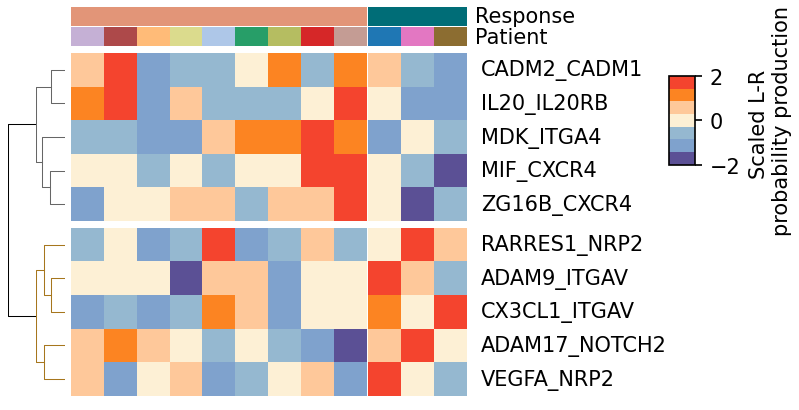

In [13]:
mtrx = dt.pivot_table(index=['group','sample'],columns=['lr_interaction'],values='scaled_LR_pb_prod').reset_index().set_index('sample')
top_anno = mtrx.group.to_frame()
top_anno['Patient'] = top_anno.index.map(lambda x:x.split('.')[0])
plt.figure(figsize=(4, 3),dpi=150)
col_ha = HeatmapAnnotation(Response=anno_simple(top_anno.group,colors={'R_Baseline':COLOR_PAlETTE['BestResponse']['favorable response\n(RCB 0-I)'],
                                                                   'NR_Baseline':COLOR_PAlETTE['BestResponse']['unfavorable response\n(RCB II-III)']},legend=False),
                           Patient=anno_simple(top_anno.Patient,colors={ k:v for k,v in COLOR_PAlETTE['Patient'].items() if k in top_anno.Patient.tolist()},legend=False),
                          )
cm = ClusterMapPlotter(data=mtrx.drop(['group'],axis=1).T, top_annotation=col_ha, row_split=2,
                       col_split=top_anno.group,
                     row_split_gap=1,label='Scaled L-R \nprobability production',row_dendrogram=True,show_rownames=True,show_colnames=False,
                     tree_kws={'row_cmap': 'Dark2_r'},cmap=my_cmap,vmin=-2,vmax=2)
plt.show()

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 7.5 mm


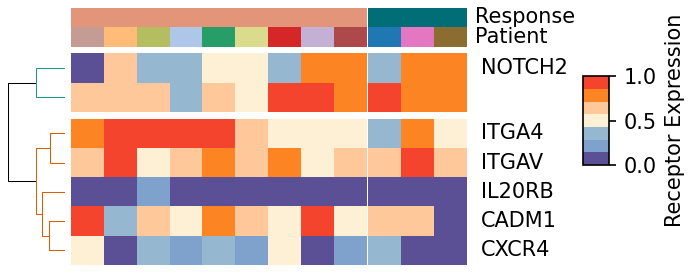

In [14]:
mtrx = dt.pivot_table(index=['group','sample'],columns=['receptor'],values='avg_receptor').reset_index().set_index('sample')
top_anno = mtrx.group.to_frame()
top_anno['Patient'] = top_anno.index.map(lambda x:x.split('.')[0])
plt.figure(figsize=(4, 2),dpi=150)
col_ha = HeatmapAnnotation(Response=anno_simple(top_anno.group,colors={'R_Baseline':COLOR_PAlETTE['BestResponse']['favorable response\n(RCB 0-I)'],
                                                                   'NR_Baseline':COLOR_PAlETTE['BestResponse']['unfavorable response\n(RCB II-III)']},legend=False),
                           Patient=anno_simple(top_anno.Patient,colors={ k:v for k,v in COLOR_PAlETTE['Patient'].items() if k in top_anno.Patient.tolist()},legend=False),
                          )
cm = ClusterMapPlotter(data=mtrx.drop(['group'],axis=1).T, top_annotation=col_ha, row_split=2,
                       col_split=top_anno.group,
                     row_split_gap=1,label='Receptor Expression',row_dendrogram=True,show_rownames=True,show_colnames=False,
                     tree_kws={'row_cmap': 'Dark2'},cmap=my_cmap,vmin=0,vmax=1)
plt.show()

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 7.5 mm


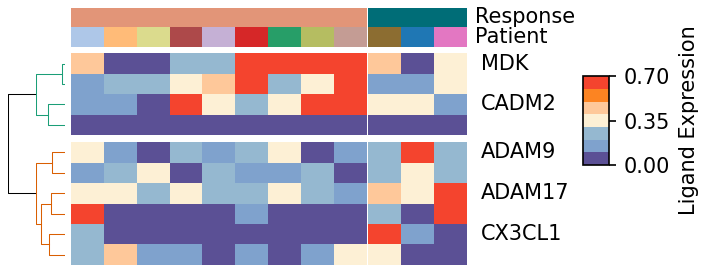

In [15]:
mtrx = dt.pivot_table(index=['group','sample'],columns=['ligand'],values='avg_ligand').reset_index().set_index('sample')
top_anno = mtrx.group.to_frame()
top_anno['Patient'] = top_anno.index.map(lambda x:x.split('.')[0])
plt.figure(figsize=(4, 2),dpi=150)
col_ha = HeatmapAnnotation(Response=anno_simple(top_anno.group,colors={'R_Baseline':COLOR_PAlETTE['BestResponse']['favorable response\n(RCB 0-I)'],
                                                                   'NR_Baseline':COLOR_PAlETTE['BestResponse']['unfavorable response\n(RCB II-III)']},legend=False),
                           Patient=anno_simple(top_anno.Patient,colors={ k:v for k,v in COLOR_PAlETTE['Patient'].items() if k in top_anno.Patient.tolist()},legend=False),
                          )
cm = ClusterMapPlotter(data=mtrx.drop(['group'],axis=1).T, top_annotation=col_ha, row_split=2,
                       col_split=top_anno.group,
                     row_split_gap=1,label='Ligand Expression',row_dendrogram=True,show_rownames=True,show_colnames=False,
                     tree_kws={'row_cmap': 'Dark2'},cmap=my_cmap,vmin=0,vmax=.7)
plt.show()

# Changes Difference
## PD1

## Top L-Rs
### Tumor-CD8T
#### rank plot

In [16]:
top_n=50
cd8_tumor_pr_delta = pr_delta.loc[(pr_delta.sender.isin(['Tumor','CD8T']))&
                            (pr_delta.receiver.isin(['Tumor','CD8T']))&
                            (pr_delta.sender!=pr_delta.receiver)].copy()

cd8_tumor_pr_delta['rank']= cd8_tumor_pr_delta.groupby(['group'])['prioritization_score'].rank(ascending=False)
lr_ids = (cd8_tumor_pr_delta.
          lr_interaction[(cd8_tumor_pr_delta['rank']<top_n) & (cd8_tumor_pr_delta.receptor.isin(theraputic_r))].
          unique()
         )
lr_ids

array(['VTCN1_BTLA', 'NECTIN2_TIGIT', 'NECTIN4_TIGIT'], dtype=object)

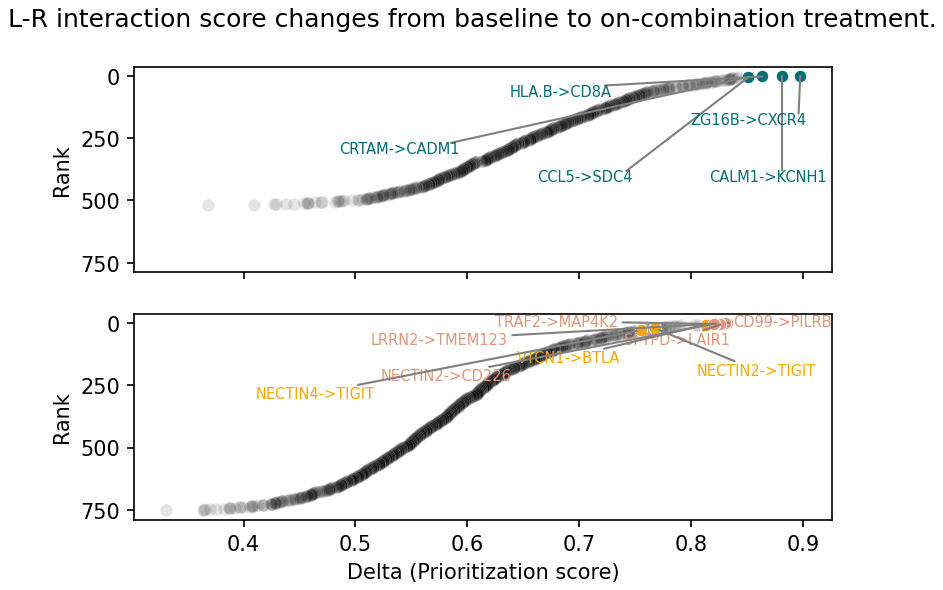

In [17]:
top_n=5
fig,axs=plt.subplots(2,1,dpi=150,sharex=True,sharey=True)
y = 'rank'
x = 'prioritization_score'


ax =axs[0]
group = 'R_W7D1'
data = cd8_tumor_pr_delta.loc[cd8_tumor_pr_delta.group==group,:].copy()
data['rank'] = data['prioritization_score'].rank(ascending=False)
sns.scatterplot(data=data,x=x,y=y,color='k',ax=ax,linewidth=.3,alpha=.1)
sub_data = data.loc[data.lr_interaction.isin(lr_ids),:]
if sub_data.shape[0]>0:
    sns.scatterplot(data=sub_data,x=x,y=y,ax=ax,color='orange')
    t_x = sub_data[x].values
    t_y = sub_data[y].values
    t_s = sub_data['id'].map(lambda x:'->'.join(x.split('_')[:2])).tolist() #+ '\n' + '->'.join(x.split('_')[2:])).tolist()
    ta.allocate(ax,t_x,t_y,t_s,x_scatter=t_x,y_scatter=t_y,
                textsize=7,
                textcolor='orange',
                direction='east',
                max_distance=1,
                min_distance=0.1,
                margin=.1,
                linecolor='gray')

sub_data = data.loc[data['rank']<=top_n,:]
sns.scatterplot(data=sub_data,x=x,y=y,ax=ax,color=COLOR_PAlETTE['BestResponse']['favorable response\n(RCB 0-I)'])
ax.invert_yaxis()
t_x = sub_data[x].values
t_y = sub_data[y].values
t_s = sub_data['id'].map(lambda x:'->'.join(x.split('_')[:2])).tolist() #+ '\n' + '->'.join(x.split('_')[2:])).tolist()
ta.allocate(ax,t_x,t_y,t_s,x_scatter=t_x,y_scatter=t_y,
            textcolor=COLOR_PAlETTE['BestResponse']['favorable response\n(RCB 0-I)'],
            textsize=7,
            max_distance=0.6,
            min_distance=0.1,
            margin=.1,
            linecolor='gray')
ax.set(ylabel="Rank");




ax =axs[1]
group = 'NR_W7D1'
data = cd8_tumor_pr_delta.loc[cd8_tumor_pr_delta.group==group,:].copy()
data['rank'] = data['prioritization_score'].rank(ascending=False)
sns.scatterplot(data=data,x=x,y=y,color='k',ax=ax,linewidth=.3,alpha=.1)
sub_data = data.loc[data.lr_interaction.isin(lr_ids),:]
texts = []
if sub_data.shape[0]>0:
    
    sns.scatterplot(data=sub_data,x=x,y=y,ax=ax,color='orange')
    t_x = sub_data[x].tolist()
    t_y = sub_data[y].tolist()
    t_s = sub_data['id'].map(lambda x:'->'.join(x.split('_')[:2])).tolist() #+ '\n' + '->'.join(x.split('_')[2:])).tolist()
    texts+=[ax.text(i,j,l, color='orange',
            fontsize=7, ha='right', va='top') for i,j,l in zip(t_x,t_y,t_s)]
    # ta.allocate(ax,t_x,t_y,t_s,x_scatter=t_x,y_scatter=t_y,
    #             textsize=7,
    #             textcolor='orange',
    #             max_distance=.1,
    #             min_distance=0,
    #             margin=.0001,
    #             linecolor='gray')
sub_data = data.loc[data['rank']<=top_n,:]
sns.scatterplot(data=sub_data,x=x,y=y,ax=ax,color=COLOR_PAlETTE['BestResponse']['unfavorable response\n(RCB II-III)'])
t_x = sub_data[x].tolist()
t_y = sub_data[y].tolist()
t_s = sub_data['id'].map(lambda x:'->'.join(x.split('_')[:2])).tolist() #+ '\n' + '->'.join(x.split('_')[2:])).tolist()

texts+=[ax.text(i,j,l, color=COLOR_PAlETTE['BestResponse']['unfavorable response\n(RCB II-III)'],
        fontsize=7, ha='right', va='top') for i,j,l in zip(t_x,t_y,t_s)]
adjust_text(texts, 
            arrowprops=dict(arrowstyle='-', color='gray')
           );
# ta.allocate(ax,t_x,t_y,t_s,x_scatter=t_x,y_scatter=t_y,
#             textcolor=COLOR_PAlETTE['BestResponse']['unfavorable response\n(RCB II-III)'],
#             textsize=7,
#             max_distance=1,
#             min_distance=0.2,
#             margin=.1,
#             avoid_label_lines_overlap=True,
#             linecolor='gray')
ax.set(ylabel="Rank",xlabel=f"Delta ({x.capitalize().replace('_',' ')})");

plt.suptitle('L-R interaction score changes from baseline to on-combination treatment.');
plt.savefig(f'{FIGURE_FOLDER}/Interaction_Tumor_CD8T_Delta_Rankplot.pdf',dpi=200)

#### paired boxplot R

In [18]:
top_n=3
cd8_tumor_pr_delta = pr_delta.loc[(pr_delta.sender.isin(['Tumor','CD8T']))&
                            (pr_delta.receiver.isin(['Tumor','CD8T']))&
                            (pr_delta.sender!=pr_delta.receiver)].copy()

cd8_tumor_pr_delta['rank']= cd8_tumor_pr_delta.groupby(['group'])['prioritization_score'].rank(ascending=False)

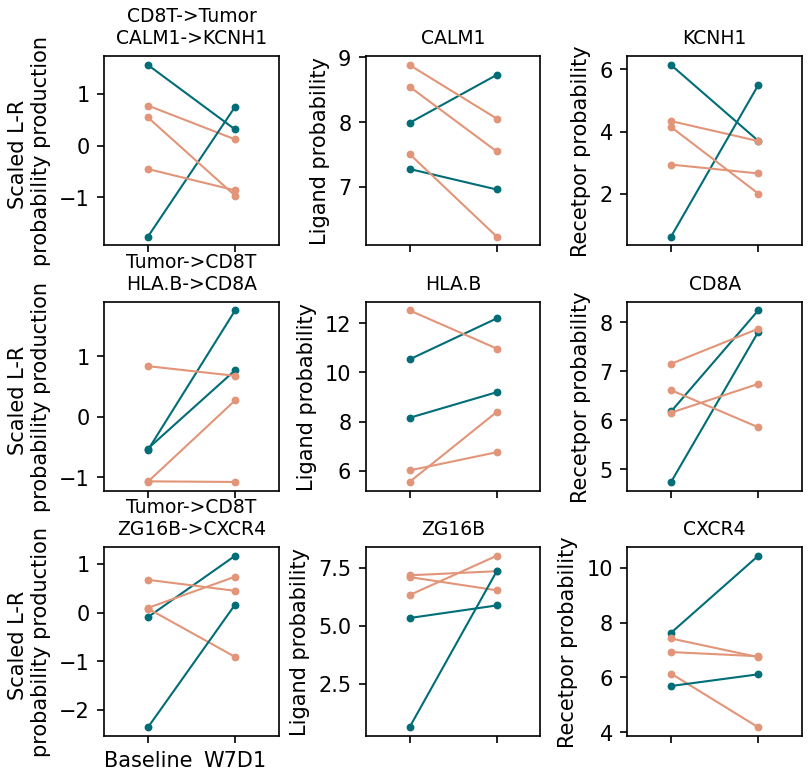

In [19]:
lr_ids = (cd8_tumor_pr_delta.
          lr_interaction[(cd8_tumor_pr_delta['rank']<=top_n)&(cd8_tumor_pr_delta.group=='R_W7D1')].
          unique()
         )

vis_data =lr_prod_delta.loc[(lr_prod_delta.sender.isin(['Tumor','CD8T']))&
                            (lr_prod_delta.receiver.isin(['Tumor','CD8T']))&
                            (lr_prod_delta.receiver!=lr_prod_delta.sender)&
                            (lr_prod_delta.lr_interaction.isin(lr_ids))].copy()

vis_data['contrast'] = vis_data['group'].map(lambda x:x.split('_')[0])
vis_data['timepoint'] = vis_data['group'].map(lambda x:x.split('_')[1])
vis_data['Patient'] = vis_data['sample'].map(lambda x:x.split('.')[0])
palette=(vis_data.drop_duplicates(['Patient']).
         set_index('Patient')['contrast'].
         map({'R':COLOR_PAlETTE['BestResponse']['favorable response\n(RCB 0-I)'],
              'NR':COLOR_PAlETTE['BestResponse']['unfavorable response\n(RCB II-III)']}).
         to_dict()
        )
order = ['Baseline','W7D1']
fig,axs = plt.subplots(3,3,dpi=150,figsize=(6,6),sharex=False,sharey=False)
for i,(lr,data) in enumerate(vis_data.groupby('id')):
    ax = axs[i,0]
    sns.pointplot(data=data,
                     x='timepoint',
                     y='scaled_LR_pb_prod',
                     order=order,
                     hue='Patient',
                     palette=palette,
                     ax=ax,
                    markersize=3,
                    linewidth=1)
    ax.legend_.remove()
    ax.set(xlabel='',ylabel=lr)
    ax.set(xlabel='',ylabel='Scaled L-R \nprobability production')
    ax.set_title('->'.join(lr.split('_')[2:]) +'\n' +'->'.join(lr.split('_')[:2]),size=9)
    if i !=2:
        ax.set_xticklabels([])
        
    ax = axs[i,1]
    sns.pointplot(data=data,
                     x='timepoint',
                     y='pb_ligand',
                  order=order,
                     hue='Patient',
                     palette=palette,
                     ax=ax,
                    markersize=3,
                    linewidth=1)
    ax.legend_.remove()
    ax.set(xlabel='',ylabel='Ligand probability')
    ax.set_title(lr.split('_')[0],size=9)
    if i !=3:
        ax.set_xticklabels([])

    ax = axs[i,2]
    sns.pointplot(data=data,
                     x='timepoint',
                     y='pb_receptor',
                  order=order,
                     hue='Patient',
                     palette=palette,
                     ax=ax,
                    markersize=3,
                    linewidth=1)
    ax.legend_.remove()
    ax.set(xlabel='',ylabel='Recetpor probability')
    ax.set_title(lr.split('_')[1],size=9)
    if i !=3:
        ax.set_xticklabels([])
plt.subplots_adjust(wspace=.5,hspace=.3)

#### paired boxplot NR

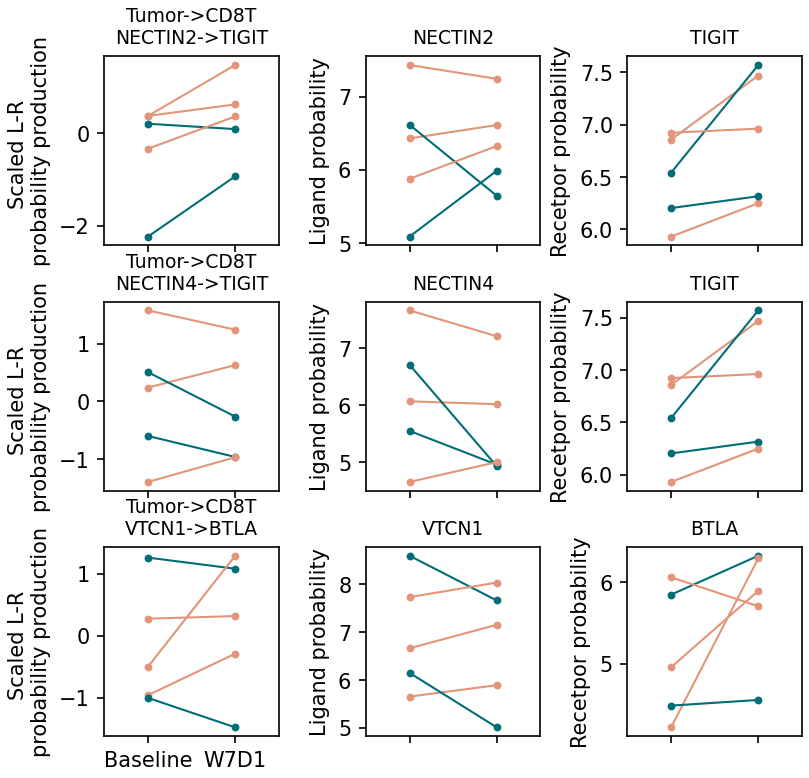

In [20]:
# lr_ids = (cd8_tumor_pr_delta.
#           id[(cd8_tumor_pr_delta['rank']<=top_n)&(cd8_tumor_pr_delta.group=='NR_W7D1')].
#           unique()
#          )
lr_ids = ['VTCN1_BTLA_Tumor_CD8T', 'NECTIN2_TIGIT_Tumor_CD8T',
       'NECTIN4_TIGIT_Tumor_CD8T']
vis_data =lr_prod_delta.loc[(lr_prod_delta.sender.isin(['Tumor','CD8T']))&
                            (lr_prod_delta.receiver.isin(['Tumor','CD8T']))&
                             (lr_prod_delta.receiver!=lr_prod_delta.sender)&
                            (lr_prod_delta.id.isin(lr_ids))].copy()

vis_data['contrast'] = vis_data['group'].map(lambda x:x.split('_')[0])
vis_data['timepoint'] = vis_data['group'].map(lambda x:x.split('_')[1])
vis_data['Patient'] = vis_data['sample'].map(lambda x:x.split('.')[0])
palette=(vis_data.drop_duplicates(['Patient']).
         set_index('Patient')['contrast'].
         map({'R':COLOR_PAlETTE['BestResponse']['favorable response\n(RCB 0-I)'],
              'NR':COLOR_PAlETTE['BestResponse']['unfavorable response\n(RCB II-III)']}).
         to_dict()
        )
order = ['Baseline','W7D1']
fig,axs = plt.subplots(3,3,dpi=150,figsize=(6,6),sharex=False,sharey=False)
for i,(lr,data) in enumerate(vis_data.groupby('id')):
    ax = axs[i,0]
    sns.pointplot(data=data,
                     x='timepoint',
                     y='scaled_LR_pb_prod',
                     order=order,
                     hue='Patient',
                     palette=palette,
                     ax=ax,
                    markersize=3,
                    linewidth=1)
    ax.legend_.remove()
    ax.set(xlabel='',ylabel=lr)
    ax.set(xlabel='',ylabel='Scaled L-R \nprobability production')
    ax.set_title('->'.join(lr.split('_')[2:]) +'\n' +'->'.join(lr.split('_')[:2]),size=9)
    if i !=2:
        ax.set_xticklabels([])
        
    ax = axs[i,1]
    sns.pointplot(data=data,
                     x='timepoint',
                     y='pb_ligand',
                  order=order,
                     hue='Patient',
                     palette=palette,
                     ax=ax,
                    markersize=3,
                    linewidth=1)
    ax.legend_.remove()
    ax.set(xlabel='',ylabel='Ligand probability')
    ax.set_title(lr.split('_')[0],size=9)
    if i !=3:
        ax.set_xticklabels([])

    ax = axs[i,2]
    sns.pointplot(data=data,
                     x='timepoint',
                     y='pb_receptor',
                  order=order,
                     hue='Patient',
                     palette=palette,
                     ax=ax,
                    markersize=3,
                    linewidth=1)
    ax.legend_.remove()
    ax.set(xlabel='',ylabel='Recetpor probability')
    ax.set_title(lr.split('_')[1],size=9)
    if i !=3:
        ax.set_xticklabels([])
plt.subplots_adjust(wspace=.5,hspace=.3)

### Tumor-Macrophage
#### rank plot

In [21]:
macs_tumor_pr_delta = pr_delta.loc[(pr_delta.sender.isin(['Tumor','Macs']))&
                            (pr_delta.receiver.isin(['Tumor','Macs']))&
                            (pr_delta.sender!=pr_delta.receiver)].copy()

macs_tumor_pr_delta['rank']= macs_tumor_pr_delta.groupby(['group'])['prioritization_score'].rank(ascending=False)

#### heatmap

In [23]:
lr_ids = macs_tumor_pr_delta.id[macs_tumor_pr_delta['rank']<=top_n]
dt = lr_prod_delta.loc[lr_prod_delta.id.isin(lr_ids),:]
dt['Timepoint'] = dt['group'].map(lambda x:x.split("_")[1])
dt['BCR'] = dt['group'].map(lambda x:x.split("_")[0]).map({
    'R':'favorable response\n(RCB 0-I)',
    'NR':'unfavorable response\n(RCB II-III)'
})
dt['Patient'] = dt['sample'].map(lambda x:x.split('.')[0])

In [24]:
mtrx = dt.pivot_table(index=['Timepoint','BCR','Patient'],columns=['id'],values='scaled_LR_pb_prod')
delta = (mtrx.loc['W7D1',:] - mtrx.loc['Baseline',:]).reset_index()
delta

id,BCR,Patient,HEBP1_FPR3_Tumor_Macs,HLA.DRA_CD81_Macs_Tumor,HLA.DRA_CD9_Macs_Tumor,LGALS9_CD44_Macs_Tumor,LRP1B_PLAUR_Tumor_Macs,MMP9_DDR1_Macs_Tumor,NECTIN2_NECTIN4_Macs_Tumor,VEGFA_NRP1_Tumor_Macs,VEGFA_NRP2_Tumor_Macs,ZG16B_TLR4_Tumor_Macs
0,favorable response\n(RCB 0-I),P01,-0.501892,0.791535,0.814863,0.371505,0.592869,1.310345,-0.684479,-2.314856,-1.192740,0.208021
1,favorable response\n(RCB 0-I),P08,-2.667198,1.246804,0.966556,-1.221276,-0.695704,0.948352,-2.354384,-1.636010,-1.695336,3.436569
2,unfavorable response\n(RCB II-III),P12,-0.594267,-0.005885,-0.340081,1.395584,0.236588,-1.995659,-0.168074,1.529919,0.665495,0.754962
3,unfavorable response\n(RCB II-III),P13,-0.409072,0.042590,-0.431610,0.519290,0.091941,-1.183029,-0.338764,-0.172146,0.326239,-0.359446
4,unfavorable response\n(RCB II-III),P18,0.322603,-0.460888,-0.406149,1.264165,-1.702705,-0.066718,-0.280008,1.212455,0.959251,0.186341


Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 78.67083333333333 mm
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..


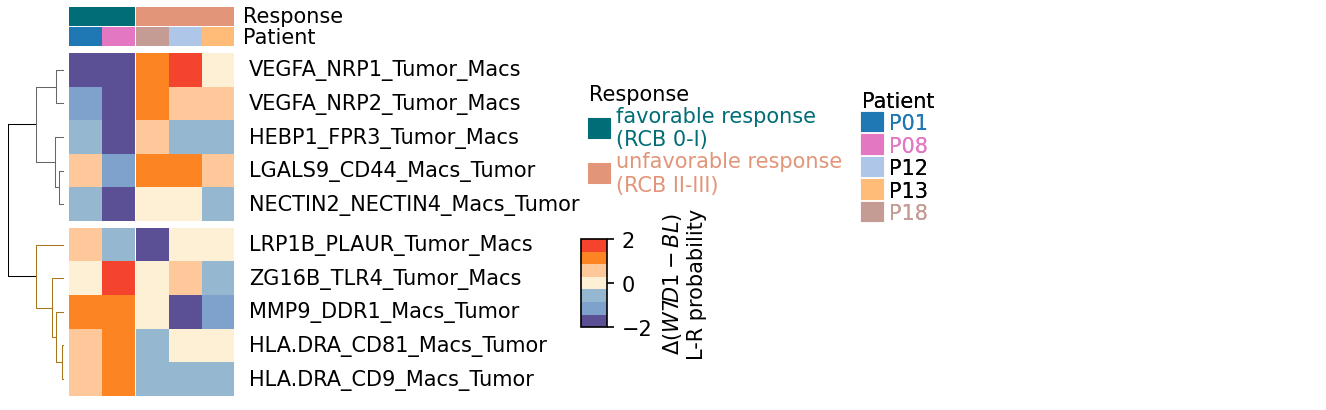

In [25]:
top_anno = delta[['Patient','BCR']]
plt.figure(figsize=(2, 3),dpi=150)
col_ha = HeatmapAnnotation(Response=anno_simple(top_anno.BCR,colors={k:v for k,v in COLOR_PAlETTE['BestResponse'].items() if k !='N/A'},
                                                #{'R':COLOR_PAlETTE['BestResponse']['favorable response\n(RCB 0-I)'],
                                                 #                  'NR':COLOR_PAlETTE['BestResponse']['unfavorable response\n(RCB II-III)']},
                                                legend_kws={'frameon':False}),
                           Patient=anno_simple(top_anno.Patient,
                                               colors={ k:v for k,v in COLOR_PAlETTE['Patient'].items() if k in top_anno.Patient.tolist()},
                                               legend_kws={'frameon':False})
                          )
cm = ClusterMapPlotter(data=delta.drop(top_anno.columns.tolist(),axis=1).T, top_annotation=col_ha, row_split=2,
                       col_split=top_anno['BCR'],
                     row_split_gap=1,label=r'$\Delta(W7D1-BL)$'+ '\nL-R probability',row_dendrogram=True,show_rownames=True,show_colnames=False,
                     tree_kws={'row_cmap': 'Dark2_r'},cmap=my_cmap,vmin=-2,vmax=2)
plt.show()